In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
import os
from collections import defaultdict, OrderedDict
import json
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import matplotlib.pyplot as plt

In [2]:
from data_access.load_file import *
from data_processing.functions import *
from data_processing.processmining import *
from vizualizations import *

In [3]:
"""
To ignore the pandas SettingWithCopyWarning in cell 5 function time_for_phase
If you have the solution to optimize the function please contact :)
"""
import warnings
warnings.filterwarnings('ignore')

In [4]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
data.sort_values(by='timestamp', inplace=True)
data["from_resource"].fillna("0", inplace=True)
data["to_resource"].fillna("0", inplace=True)
data = add_phase(data, col_name="process_phase", cols=["from_phase", "to_phase"], as_str=False)
data = add_phase(data, col_name="resource_phase", cols=["from_resource", "to_resource"], as_str=False)

Let's get into resource Phases! First restrict on closed items

In [5]:
isclosed = data[data["to_phase"]=="End"]["work_item"].unique()

In [6]:
closed = data[data["work_item"].isin(isclosed)]

In [7]:
closed[closed["from_resource"]=="0"]["from_phase"].value_counts()

Start    10522
Name: from_phase, dtype: int64

In [8]:
closed[closed["from_phase"]=="Start"]["from_resource"].value_counts(dropna=False)

0    10522
Name: from_resource, dtype: int64

Everery Resource start from NaN.

In [9]:
print("There are %i different resource states and %i different resource phases" %(closed["to_resource"].nunique(), closed["resource_phase"].nunique()))

There are 270 different resource states and 2371 different resource phases


Count the different paths a resource can go

In [10]:
procfreq = count_processes(closed, "resource_phase")
processes = dict_to_df(procfreq).T
processes.sort_values(by="freq", ascending=False, inplace=True)
processes.reset_index(drop=True, inplace=True)

In [11]:
save_path = Path("../plots/")

In [12]:
g1 = plot_process(process=processes["process"][0].values(), name="Resource_top_Frequency", path=save_path)
g2 = plot_process(process=processes["process"][1].values(), name="Resource_second_Frequency", path=save_path)
g3 = plot_process(process=processes["process"][2].values(), name="Resource_third_Frequency", path=save_path)

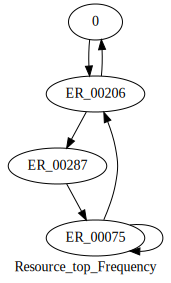

In [13]:
g1

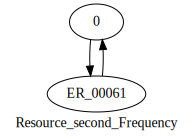

In [14]:
g2

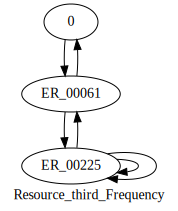

In [15]:
g3

In [16]:
closed["to_resource"].value_counts().head(8)

0           10522
ER_00239     2979
ER_00225     2530
ER_00149     2352
ER_00251     2198
ER_00061     2188
ER_00212     2047
ER_00060     1890
Name: to_resource, dtype: int64

We can see that Resources are going forward and back or stay in the same state. Let's see what happens with the resource phase if the process phase stays on same stage

In [17]:
process_hold = closed[closed["from_phase"]==closed["to_phase"]]
resource_change = process_hold[process_hold["resource_phase"].apply(lambda x: x[0] != x[1])]
resource_hold = process_hold[process_hold["resource_phase"].apply(lambda x: x[0] == x[1])]

In [18]:
print("In %i cases the resource changes, if the process holds." %len(resource_change))
print("In %i cases the resource holds, if the process holds." %len(resource_hold))

In 171 cases the resource changes, if the process holds.
In 0 cases the resource holds, if the process holds.


This is a useful information. If the process flow stops, the resource is changed. If the resource is a person this could have multiple reasons. The things we should to get know more about are:

1. What is the correlation between the process flow and the resource flow, which resource corresponds to which process phase
2. Which resource needs most time
3. Why is a resource changing

First we calculate times and wrangle the data

In [19]:
relevant_columns = ["work_item", "process_phase", "resource_phase", "timestamp"]
times = time_for_phase(data, relevant_columns=[*relevant_columns, "to_resource"], process=True, end_date=None)

In [20]:
duration_type = ["duration_in_days", "duration_in_hours", "duration_in_minutes"]

In [21]:
new_names = {
            "to_phase": "current_phase",
            "process_phase_x": "from_process",
            "process_phase_y": "to_process",
            "to_resource_x": "current_resource",
            "resource_phase_x": "from_resource",
            "resource_phase_y": "to_resource"
            }
times.rename(columns=new_names, inplace=True)
relevant_cols = ["work_item", "process_index", *list(new_names.values()), "duration_in_days"]
times= times[relevant_cols]

In [22]:
times.head()

,work_item,process_index,current_phase,from_process,to_process,current_resource,from_resource,to_resource,duration_in_days
0,WI_000001,1,Analyze,"(Start, Analyze)","(Analyze, Design)",ER_00043,"(0, ER_00043)","(ER_00043, ER_00149)",2.88
1,WI_000002,1,Analyze,"(Start, Analyze)","(Analyze, Design)",ER_00225,"(0, ER_00225)","(ER_00225, ER_00225)",11.78
2,WI_000003,1,Analyze,"(Start, Analyze)","(Analyze, Design)",ER_00225,"(0, ER_00225)","(ER_00225, ER_00225)",18.84
3,WI_000004,1,Analyze,"(Start, Analyze)","(Analyze, Design)",ER_00225,"(0, ER_00225)","(ER_00225, ER_00239)",11.80
4,WI_000005,1,Analyze,"(Start, Analyze)","(Analyze, Design)",ER_00206,"(0, ER_00206)","(ER_00206, ER_00075)",25.69


In [23]:
is_open = pd.isnull(times["duration_in_days"])
times_open = times[is_open]
times_closed = times[~is_open]

In [24]:
categories = ["Analyze", "Design", "Build", "Test", "Package", "Accept", "Deploy", "Clarify"]
times_closed.loc[:, "current_phase"] = pd.Categorical(times_closed["current_phase"], categories=categories)

Now we take a look on the correltation between the current phase and the current resource based on the most frequent 20 resources regarding to the most influencing process phases (Analyze, Design) and take a look at the first question

1. What is the correlation between the process flow and the resource flow, which resource corresponds to which process phase

In [25]:
cross = pd.crosstab(times_closed["current_phase"], times_closed["current_resource"])
cross = cross.reindex(categories).T

In [26]:
top20 = cross.nlargest(20, columns=["Analyze", "Design"])

Text(0.5, 1.0, 'Most frequent resource phases regarding to the process phases')

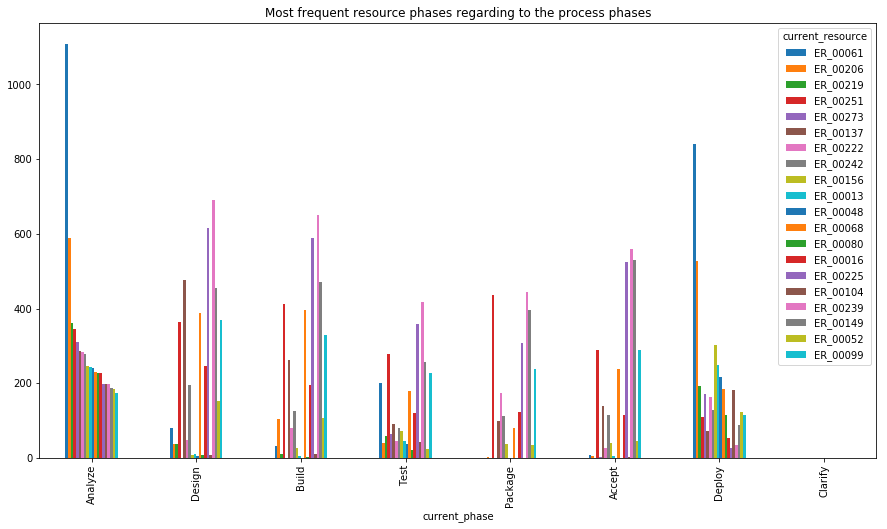

In [27]:
top20.T.plot(kind='bar', figsize=(15,8))
plt.title("Most frequent resource phases regarding to the process phases")

We can see that resources ER_00061 and ER_00206 going along with the phase Analyze and Deploy, while ER_00239 and ER_00225 going along with Design, Build, Test, Package and Accept. Let's look at the time

2. Which resource needs most time

In [28]:
resource_freq = times_closed.groupby("current_resource").size()
resource_sum = pd.DataFrame(times_closed.groupby("current_resource")[duration_type[0]].sum() / resource_freq)
resource_sum.rename(columns={0: "duration_in_days"}, inplace=True)
toptime = resource_sum.nlargest(20, columns="duration_in_days")

Text(0.5, 0, 'duration_in_days / frequency')

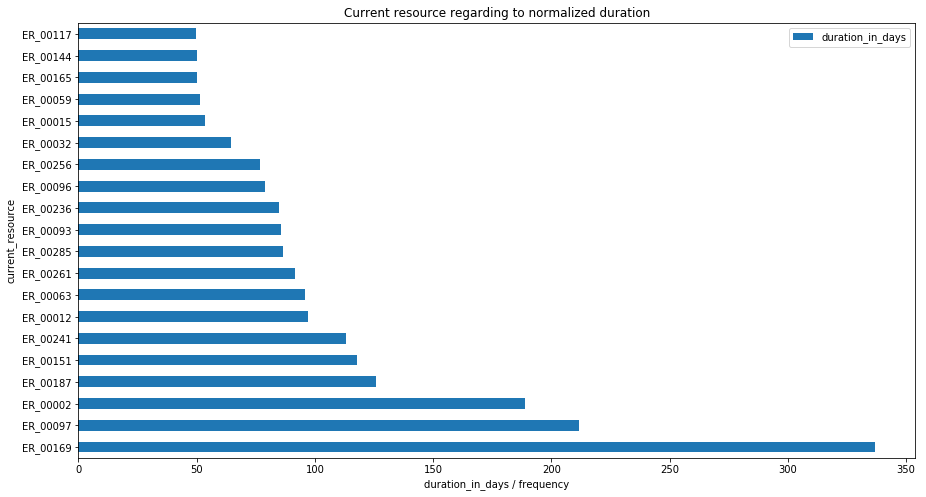

In [29]:
toptime.plot(kind='barh',figsize=(15,8), title="Current resource regarding to normalized duration")
plt.xlabel("duration_in_days / frequency")

Store into json for usage in models

In [30]:
# filepath = Path("../data/top20_time_resources.json")
# with open(filepath, 'w') as f:
#     json.dump(list(toptime.index), f)

We can see that the resources ER_00169, ER_00097 and ER_00002 need the most time to get things done. We should compare with the resources from 1.

In [31]:
print("The following resources have a high impact based on the process phases and the time: \n{}".format(set(toptime.index.values) & set(top20.index.values)))

The following resources have a high impact based on the process phases and the time: 
set()


Sadly the intersection is 0. But we should check the rank of the resources that are related to the process phases

In [32]:
ranks = resource_sum.reset_index().sort_values(by="duration_in_days", ascending=False).reset_index(drop=True)

In [33]:
print("The both resources that have highest relation to the phases Analyze and Deploy:")
print("The rank of resource of ER_00061 is %i"%ranks[ranks["current_resource"]=="ER_00061"].index[0])
print("The rank of resource of ER_00206 is %i"%ranks[ranks["current_resource"]=="ER_00206"].index[0])
print("The both resources that have highest relation to the phases Design, Build, Test, Package and Accept:")
print("The rank of resource of ER_00239 is %i"%ranks[ranks["current_resource"]=="ER_00239"].index[0])
print("The rank of resource of ER_00225 is %i"%ranks[ranks["current_resource"]=="ER_00225"].index[0])
print("\nWhile the highest rank is %i"%len(ranks))

The both resources that have highest relation to the phases Analyze and Deploy:
The rank of resource of ER_00061 is 73
The rank of resource of ER_00206 is 172
The both resources that have highest relation to the phases Design, Build, Test, Package and Accept:
The rank of resource of ER_00239 is 144
The rank of resource of ER_00225 is 123

While the highest rank is 273


So let's have a look on the third question:

3. Why is a resource changing

With question 1 we already have a possible answer for that:

Resources could change regarding the process phases. So resources could represent employees in the business process with specific roles like an Analyst, a Developer (Conceptional, Software, Packaging) or an Engineer.

With question 2 we have an other aproach:

Resources could represent physical or technical things like working environment, files or tools that are involved

So we can summarize the following:
1. When the ticket comes in it doesn't have a resource
2. Resources are undirected and can 'point on themselves' (like ER_000 -> ER_000)
3. If the process phase doesn't change the resource phase changes and this takes time too
4. There are resources that are correlated with process phases and the duration time